## Analysis of drug reviews

In this notebook, I used Machine Learning and Natural Language Processing (NLP) technology to predict a drug rating score based on patient reviews. Learning from the experience of real people who have taken drug treatments can help other patients to find the most effective drug. The dataset is from Kaggle's website. The main goal of this notebook is using various NLP techniques to convert reviews into numerical values and then evaluate their performance in terms of text classification accuracy.

1. [Exploratory Data Analysis](#1)
2. [Text preprocessing](#2)
3. [Word Embedding](#3)
4. [Classification](#4)
5. [Results Analysis](#5)
6. [Conclusion ](#6)

In [1]:
# general
import numpy as np
import pandas as pd
from datetime import datetime

# visiualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# nlp
from collections import Counter
import re
from gensim.models import KeyedVectors
from spacy.lang.en.stop_words import STOP_WORDS
import string
from spacy.lang.en import English
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

# modeling
from keras import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint

# results analysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, auc, roc_curve

Using TensorFlow backend.


## Exploratory Data Analysis <a name='1'></a>

In [2]:
# reading data
df_train = pd.read_csv('drugsComTrain_raw.csv')
df_test = pd.read_csv('drugsComTest_raw.csv')

In [3]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
df_test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [5]:
df_train.describe()

,uniqueID,rating,usefulCount
count,161297.000000,161297.000000,161297.000000
mean,115923.585305,6.994377,28.004755
std,67004.445170,3.272329,36.403742
min,2.000000,1.000000,0.000000
25%,58063.000000,5.000000,6.000000
50%,115744.000000,8.000000,16.000000
75%,173776.000000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [6]:
df_test.describe()

,uniqueID,rating,usefulCount
count,53766.000000,53766.000000,53766.000000
mean,116386.701187,6.976900,27.989752
std,67017.739881,3.285207,36.172833
min,0.000000,1.000000,0.000000
25%,58272.500000,4.000000,6.000000
50%,116248.500000,8.000000,16.000000
75%,174586.750000,10.000000,36.000000
max,232284.000000,10.000000,949.000000


Insights: The dataset has 7 columns, 3 of which are utilized in this study: review, rating, and usefulCount. 

In [7]:
print("Training Dataset Dimension: {} Rows, {} Columns".format(*df_train.shape))
pd.DataFrame(data=[df_train.nunique(), df_train.isnull().sum()], index=['unique', 'null'])

Training Dataset Dimension: 161297 Rows, 7 Columns


,uniqueID,drugName,condition,review,rating,date,usefulCount
unique,161297,3436,884,112329,10,3579,389
null,0,0,899,0,0,0,0


In [8]:
print("Testing Dataset Dimension: {} Rows, {} Columns".format(*df_test.shape))
pd.DataFrame(data=[df_test.nunique(), df_train.isnull().sum()], index=['unique', 'null'])

Testing Dataset Dimension: 53766 Rows, 7 Columns


,uniqueID,drugName,condition,review,rating,date,usefulCount
unique,53766,2637,708,48280,10,3566,325
null,0,0,899,0,0,0,0


Insights: There are 899 missing values in each training and testing dataset, which represents 0.05% and 1.6% of the dataset, respectively. Since the missing values consist of a small portion of the dataset, I simply drop them.

In [3]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

Let's take a look at the distribution of variables!

16.0


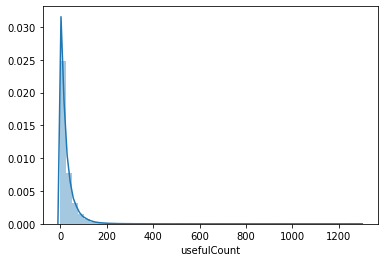

In [10]:
sns.distplot(df_train['usefulCount'])
print(df_train['usefulCount'].median())

8.0


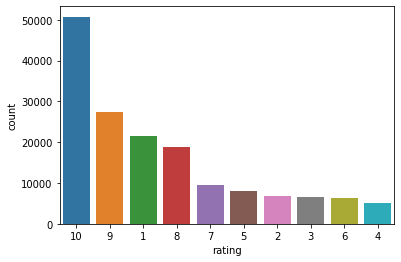

In [11]:
sns.countplot(x='rating', data=df_train ,order=df_train['rating'].value_counts().index)
print(df_train['rating'].median())

Insights: UsefulCount is an integer number that shows how many patients have found the review useful. It ranges from 0 to 1291, with a median of 16. 
Rating is an integer number between 1 to 10. Highly positive (9, 10) and highly negative (1) ratings are more common than neutral opinions (3,4,5).

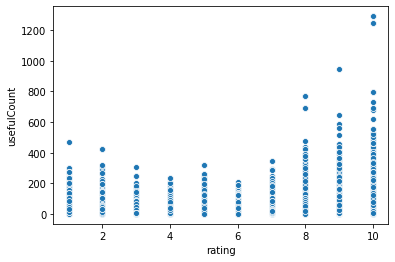

In [12]:
sns.scatterplot(x='rating', y='usefulCount', data=df_train)

Insight: Highly positive and highly negative reviews have higher useful counts compare to neutral reviews. This is something that usually happens because none-neutral opinions usually contain more important information.

## Text preprocessing <a name='2'></a>

In [4]:
punctuations = string.punctuation
stopwords = STOP_WORDS
def cleaning(sentence):
    tokens = [tok.lemma_.lower().strip() for tok in sentence if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
    tokens = [tok for tok in tokens if tok.find('.') == -1 and tok.find(':') == -1 and tok.find('/') == -1]
    cleaned_sentence = " ".join(tokens)
    return cleaned_sentence

In [5]:
def tokenizing(df):
    docs = []
    for sent in df.sents:
        cleaned_sent = cleaning(sent)
        docs.append(cleaned_sent)
    return docs

In [6]:
# tokenizing and cleaning each sentence
nlp = English()
sbd = nlp.create_pipe('sentencizer')
nlp.add_pipe(sbd)

df_train['cleaned_review'] = df_train['review'].apply(lambda x: x.replace("'", ''))
df_train['cleaned_review'] = df_train['cleaned_review'].apply(lambda x: x.replace("&#039;", ''))
df_train['cleaned_review'] = df_train['cleaned_review'].apply(lambda x: re.sub('[^a-zA-Z._]', ' ', x))
df_train['cleaned_review'] = df_train['cleaned_review'].apply(lambda x: nlp(x))
df_train['cleaned_review'] = df_train['cleaned_review'].apply(tokenizing)
df_train['cleaned_review'] = df_train['cleaned_review'].apply(lambda x: ' '.join(x))
df_train['cleaned_review_sent'] = df_train['cleaned_review'].apply(lambda x: x.split())

df_test['cleaned_review'] = df_test['review'].apply(lambda x: x.replace("'", ''))
df_test['cleaned_review'] = df_test['cleaned_review'].apply(lambda x: x.replace("&#039;", ''))
df_test['cleaned_review'] = df_test['cleaned_review'].apply(lambda x: re.sub('[^a-zA-Z._]', ' ', x))
df_test['cleaned_review'] = df_test['cleaned_review'].apply(lambda x: nlp(x))
df_test['cleaned_review'] = df_test['cleaned_review'].apply(tokenizing)
df_test['cleaned_review'] = df_test['cleaned_review'].apply(lambda x: ' '.join(x))
df_test['cleaned_review_sent'] = df_test['cleaned_review'].apply(lambda x: x.split())

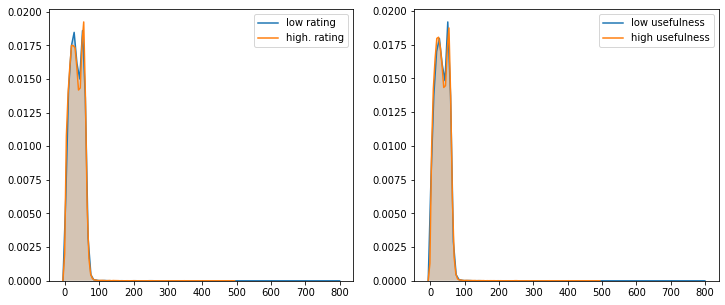

In [7]:
# calculatin number of words in each review
df_train['Word Count'] = df_train['cleaned_review_sent'].apply(len)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

#using mean to convert the rating to low rating and high rating
sns.kdeplot(df_train['Word Count'][df_train['rating']<=8], label='low rating', shade=True, ax=ax1)
sns.kdeplot(df_train['Word Count'][df_train['rating']>8], label='high. rating', shade=True, ax=ax1)


#using mean to convert the useful count to low usefulness and high usefulness
sns.kdeplot(df_train['Word Count'][df_train['usefulCount']<=16], label='low usefulness', shade=True, ax=ax2)
sns.kdeplot(df_train['Word Count'][df_train['usefulCount']>16], label='high usefulness', shade=True, ax=ax2)

Insight: There is no significant difference between the number of words for low rating and high rating. The same is correct for useful count.  

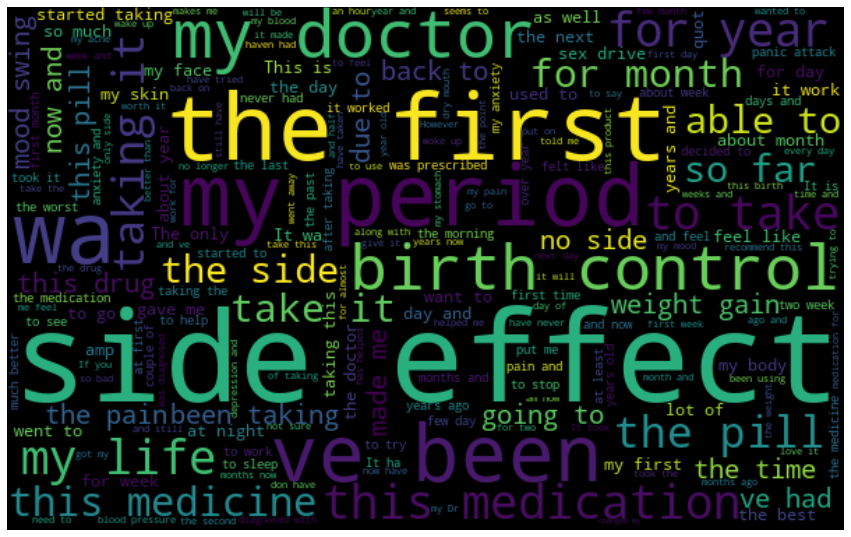

In [17]:
wordcloud = WordCloud(width=600, height=375, random_state=21, max_font_size=110).generate(' '.join(df_train.review))
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Word Embedding <a name='3'></a>

Once we have cleaned and tokenized our reviews, we need to turn them into numerical vectors that our machine learning models can process. I use two commonly used models, namely word2vec and doc2vec for this purpose. 
Word2vec, which is a word embedding technique, represents each word with a vector space, where the location and distance between words indicate how similar they are semantical. For review classification, we need to represent the entire reviews as single vectors. The most straightforward way to do so is by taking the arithmetic mean of the words. A more sophisticated method would be using TFIDF, which penalizes common words that occur at similar frequencies in all documents. 
Doc2vec, on the other hand, creates a numeric representation of the whole document, regardless of its length. 
In the next section, I try three different approaches to calculate the embedded vectors for each review:
1- word2vec + mean
2- word2vec + tfidf
3- doc2vec

### word2vec + mean

In [8]:
def word2vec(path, sentences, embed_size, word_window, min_word_count, nepochs):
    print('w2v calculation is started!')
    w2v_model = Word2Vec(sentences, size=embed_size, window=word_window, min_count=min_word_count)
    w2v_model.train(sentences, total_examples=len(sentences), epochs=nepochs)
    w2v_model.wv.save(path)
    print('word2vec is calculated for the whole words')
    return w2v_model

In [9]:
# trainig word2vec
sentences = df_train['cleaned_review_sent'].to_list()
model_w2v = word2vec('wordvectors_whole.kv', sentences, embed_size=64, word_window=5, min_word_count=1, nepochs=100)

# loading word2vec
#model_w2v = KeyedVectors.load('wordvectors_whole.kv', mmap='r')

In [10]:
# I used tsne to convert high domentional word vectors into 2d vectors to be able to visualize them.
def tsne_plot(text, model, min_count):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    flattened_list = [y for x in text.to_list() for y in x]
    tokens_count = Counter(flattened_list)
    for word in model.wv.vocab:
        if tokens_count[word] >= min_count:
            tokens.append(model[word])
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/home/rmehrizi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


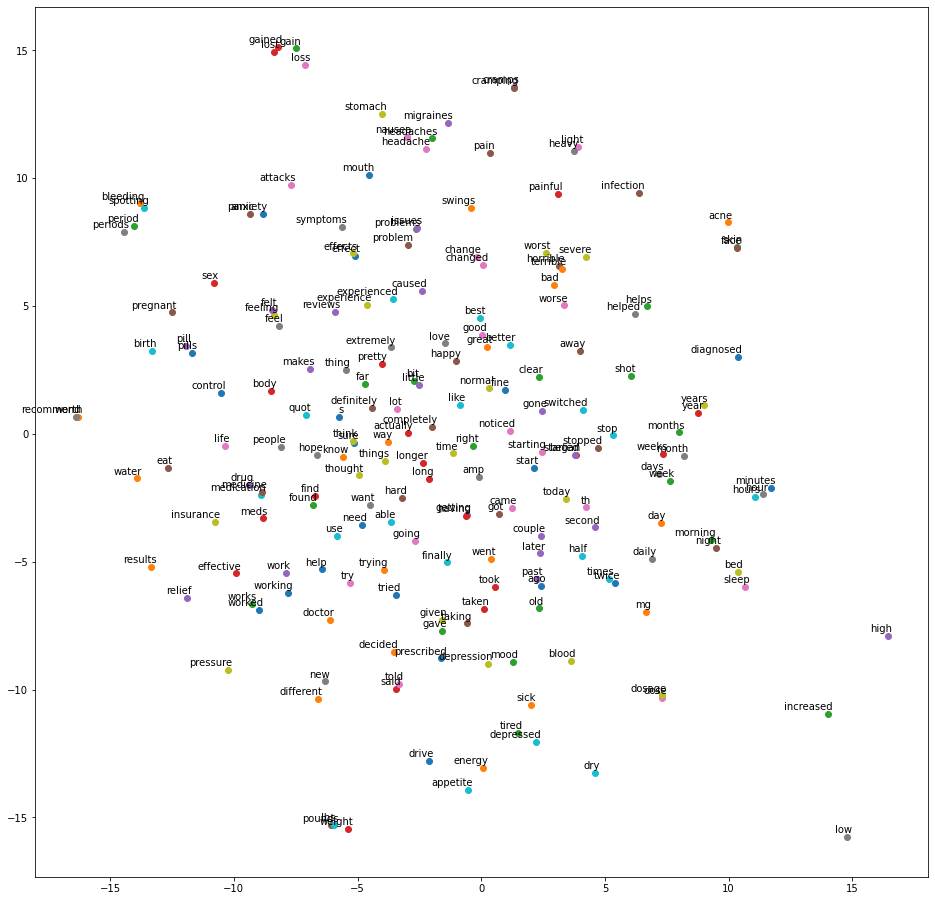

In [11]:
tsne_plot(df_train.cleaned_review_sent, model_w2v, 5000)

In [12]:
def embedding_average(text, model, embed_size):
    docs_vector = []
    for i in text.index:
        docs_vector.append(make_docs_vector(text.loc[i], model, embed_size))
    return np.array(docs_vector)

In [13]:
def make_docs_vector(text, model, embed_size):
    words = text.split(' ')
    doc_vec = np.zeros(embed_size)
    count = 0
    for word in words:
        if word in model.wv.vocab:
            word_vec = model.wv.get_vector(word)
            doc_vec += word_vec
            count += 1
           
    if len(text) == 0:
        return [0] * embed_size
    
    if count==0:
        return [0] * embed_size

    return doc_vec/count

In [14]:
# word2vec + average
x_train_w2v_ave = embedding_average(text=df_train.cleaned_review, model=model_w2v, embed_size=64)
x_test_w2v_ave = embedding_average(text=df_test.cleaned_review, model=model_w2v, embed_size=64)

/home/rmehrizi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/home/rmehrizi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


### word2vec + tfidf

In [15]:
def embedding_tfidf(text, model, embed_size):
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='latin-1', ngram_range=(1, 1))
    features = tfidf.fit_transform(text).toarray()
    words_vector = np.zeros((features.shape[1],embed_size))
    for k, v in tfidf.vocabulary_.items():
        if k in model.wv.vocab:
            words_vector[v,:] = model.wv.get_vector(k)
    docs_vector = np.mat(features) * np.mat(words_vector)
    return  np.squeeze(np.asarray(docs_vector))

In [16]:
# word2vec + tfidf
x_train_w2v_tfidf = embedding_average(text=df_train.cleaned_review, model=model_w2v, embed_size=64)
x_test_w2v_tfidf = embedding_average(text=df_test.cleaned_review, model=model_w2v, embed_size=64)

/home/rmehrizi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/home/rmehrizi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


### doc2vec

In [17]:
def doc2vec(path, text, embed_size, alpha, min_word_count, nepochs):
    print('d2v calculation will start soon!')
    text['target'] = text['rating'].apply(lambda x:0 if x<=8 else 1)
    tagged_data = []
    for idx, doc in enumerate(list(text['cleaned_review'])):
        tagged_data.append(TaggedDocument(words=doc.split(), tags=[list(text['target'])[idx]]))


    model = Doc2Vec( vector_size=embed_size,
            min_count=min_word_count,
            min_alpha=alpha,
            alpha=alpha,
        )
    model.build_vocab(tagged_data)
    for epoch in range(nepochs):
        print('epoch {0}'.format(epoch))
        model.train(tagged_data,
                    total_examples=model.corpus_count,
                    epochs=model.iter)
        model.alpha -= 0.0002
        model.min_alpha = model.alpha
    model.save(path)
    print('doc2vec is calculated for the whole docs')
    return model

In [19]:
# trainig doc2vec
model_d2v = doc2vec('docvectors.model', df_train, embed_size=64, alpha=0.0025, min_word_count=1, nepochs=10)

#loading doc2vec
#model_d2v = Doc2Vec.load('docvectors.model')

In [21]:
def embedding_doc2vec(text, model):
    docs_vector = []
    for i in text.index:
        docs_vector.append(model.infer_vector(text.loc[i]))

    return np.array(docs_vector)

In [22]:
# doc2vec
x_train_d2v = embedding_doc2vec(text=df_train.cleaned_review_sent, model=model_d2v)
x_test_d2v = embedding_doc2vec(text=df_test.cleaned_review_sent, model=model_d2v)

## Classification <a name='4'></a>

After embedding reviews, we can use the vector representations as a feature for classification. To make the problem simpler, I treat it as a binary classification by concatenating different ratings into a single group. I assign all the reviews smaller than the median (8) to the low rating group and reviews greater than the median  to high rating.

In [23]:
#making a binary classification
y_train = df_train['rating'].apply(lambda x: 0 if x<=8 else 1)
y_test = df_test['rating'].apply(lambda x: 0 if x<=8 else 1)

I use a neural network with 4 fully connected layers for classification. 

In [24]:
def create_network():
    dnn_model = Sequential()
    dnn_model.add(Dense(32, activation='relu', kernel_initializer='random_normal', input_dim=64))
    dnn_model.add(Dropout(0.5))
    dnn_model.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
    dnn_model.add(Dropout(0.5))
    dnn_model.add(Dense(8, activation='relu', kernel_initializer='random_normal'))
    dnn_model.add(Dropout(0.5))
    dnn_model.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

    return dnn_model

In [25]:
def classification(x_train, y_train, x_test, y_test, path, nepochs, batch_size):
    # create model
    dnn_model = create_network()
    # compile model
    dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])    
    
    # train
    checkpoint = ModelCheckpoint(path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    dnn_model.fit(x_train, y_train, validation_split=0.2, epochs=nepochs, batch_size=batch_size,
                  callbacks=callbacks_list, verbose=0)
    # test
    dnn_model.load_weights(path)
    dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    dnn_pred_prob = dnn_model.predict(x_test)

    return dnn_pred_prob


### word2vec + ave

In [26]:
pred_rating_w2v_ave = classification(x_train_w2v_ave, y_train, x_test_w2v_ave, y_test, 'weights.best.w2v.ave.hdf5', nepochs=100, batch_size=500)


Epoch 00001: val_loss improved from inf to 0.56747, saving model to weights.best.w2v.ave.hdf5

Epoch 00002: val_loss improved from 0.56747 to 0.55316, saving model to weights.best.w2v.ave.hdf5

Epoch 00003: val_loss improved from 0.55316 to 0.54819, saving model to weights.best.w2v.ave.hdf5

Epoch 00004: val_loss improved from 0.54819 to 0.54818, saving model to weights.best.w2v.ave.hdf5

Epoch 00005: val_loss improved from 0.54818 to 0.54459, saving model to weights.best.w2v.ave.hdf5

Epoch 00006: val_loss improved from 0.54459 to 0.54287, saving model to weights.best.w2v.ave.hdf5

Epoch 00007: val_loss did not improve from 0.54287

Epoch 00008: val_loss improved from 0.54287 to 0.54124, saving model to weights.best.w2v.ave.hdf5

Epoch 00009: val_loss improved from 0.54124 to 0.54108, saving model to weights.best.w2v.ave.hdf5

Epoch 00010: val_loss did not improve from 0.54108

Epoch 00011: val_loss improved from 0.54108 to 0.53939, saving model to weights.best.w2v.ave.hdf5

Epoch 00

### word2vec + tfidf

In [27]:
pred_rating_w2v_tfidf = classification(x_train_w2v_tfidf, y_train, x_test_w2v_tfidf, y_test, 'weights.best.w2v.tfidf.hdf5', nepochs=100, batch_size=500)


Epoch 00001: val_loss improved from inf to 0.56434, saving model to weights.best.w2v.tfidf.hdf5

Epoch 00002: val_loss improved from 0.56434 to 0.55261, saving model to weights.best.w2v.tfidf.hdf5

Epoch 00003: val_loss improved from 0.55261 to 0.54880, saving model to weights.best.w2v.tfidf.hdf5

Epoch 00004: val_loss improved from 0.54880 to 0.54771, saving model to weights.best.w2v.tfidf.hdf5

Epoch 00005: val_loss improved from 0.54771 to 0.54462, saving model to weights.best.w2v.tfidf.hdf5

Epoch 00006: val_loss improved from 0.54462 to 0.54299, saving model to weights.best.w2v.tfidf.hdf5

Epoch 00007: val_loss improved from 0.54299 to 0.54149, saving model to weights.best.w2v.tfidf.hdf5

Epoch 00008: val_loss did not improve from 0.54149

Epoch 00009: val_loss improved from 0.54149 to 0.54054, saving model to weights.best.w2v.tfidf.hdf5

Epoch 00010: val_loss improved from 0.54054 to 0.53960, saving model to weights.best.w2v.tfidf.hdf5

Epoch 00011: val_loss improved from 0.5396

### doc2vec

In [28]:
pred_rating_d2v = classification(x_train_d2v, y_train, x_test_d2v, y_test, 'weights.best.d2v.hdf5', nepochs=100, batch_size=500)


Epoch 00001: val_loss improved from inf to 0.69287, saving model to weights.best.d2v.hdf5

Epoch 00002: val_loss improved from 0.69287 to 0.69287, saving model to weights.best.d2v.hdf5

Epoch 00003: val_loss improved from 0.69287 to 0.69280, saving model to weights.best.d2v.hdf5

Epoch 00004: val_loss improved from 0.69280 to 0.68995, saving model to weights.best.d2v.hdf5

Epoch 00005: val_loss improved from 0.68995 to 0.68739, saving model to weights.best.d2v.hdf5

Epoch 00006: val_loss improved from 0.68739 to 0.68646, saving model to weights.best.d2v.hdf5

Epoch 00007: val_loss improved from 0.68646 to 0.68608, saving model to weights.best.d2v.hdf5

Epoch 00008: val_loss improved from 0.68608 to 0.68577, saving model to weights.best.d2v.hdf5

Epoch 00009: val_loss did not improve from 0.68577

Epoch 00010: val_loss improved from 0.68577 to 0.68508, saving model to weights.best.d2v.hdf5

Epoch 00011: val_loss did not improve from 0.68508

Epoch 00012: val_loss improved from 0.68508 

## Results Analysis <a name='5'></a>

Let's compare the performance of each embedding method by calculating area under the ROC curve.

In [29]:
def plot_ROC_curve(y_true, y_pred, title):

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
 
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

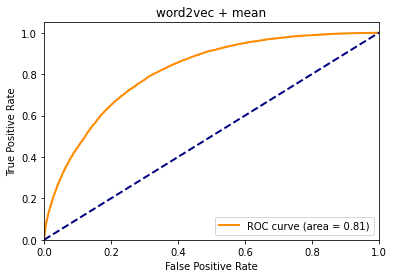

In [30]:
plot_ROC_curve(y_test, pred_rating_w2v_ave, 'word2vec + mean')

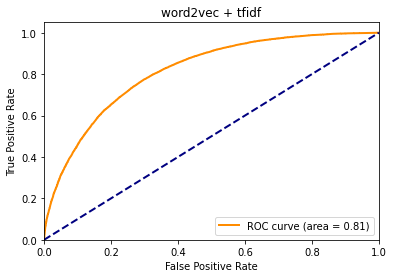

In [31]:
plot_ROC_curve(y_test, pred_rating_w2v_tfidf, 'word2vec + tfidf')

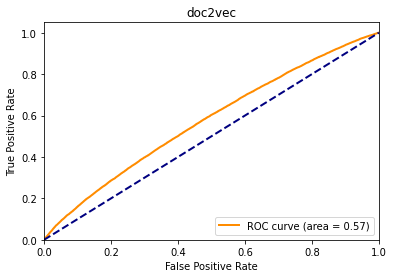

In [32]:
plot_ROC_curve(y_test, pred_rating_d2v, 'doc2vec')

In [33]:
def create_table(true, pred_prob, threshold_chunck_size):
    ppv = []
    npv = []
    sens = []
    spec = []
    cutoff = []
    table = []
    for th in np.arange(0, 1, threshold_chunck_size):
        row = []
        pred = (pred_prob > th)
        tn, fp, fn, tp = confusion_matrix(true, pred).ravel()

        ppv.append(tp / (tp + fp))
        sens.append(tp / (tp + fn))
        npv.append(tn / (tn + fn))
        spec.append(tn / (tn + fp))
        cutoff.append(th)

        row = [th, tp / (tp + fp), tp / (tp + fn), tn / (tn + fn), tn / (tn + fp), (2 * tp) / (2 * tp + fp + fn)]
        table.append(row)

    table = pd.DataFrame(table, columns=['cutoff', 'ppv', 'sensitivity', 'npv', 'specificity', 'f1 score'])
    table = table.set_index('cutoff')

    print(table)

In [34]:
def print_results(y_true, y_pred, threshold, labels = ['positive', 'negative']):
    
    pred =(y_pred > threshold)
    
    print(classification_report(y_true, pred))
    cfn_matrix = confusion_matrix(y_true, pred)
    print(cfn_matrix)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cfn_matrix)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for (i, j), z in np.ndenumerate(cfn_matrix):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    plt.show()

### word2vec + mean

In [35]:
create_table(y_test, pred_rating_w2v_ave, threshold_chunck_size=0.05)

/home/rmehrizi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app
/home/rmehrizi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


             ppv  sensitivity       npv  specificity  f1 score
cutoff                                                        
0.00    0.487311     1.000000       NaN     0.000000  0.655291
0.05    0.507595     0.997697  0.973392     0.080069  0.672861
0.10    0.526249     0.992900  0.957057     0.150398  0.687902
0.15    0.546712     0.985915  0.943373     0.223025  0.703383
0.20    0.569381     0.974134  0.924193     0.299737  0.718689
0.25    0.595948     0.955137  0.900162     0.384475  0.733954
0.30    0.627601     0.921326  0.865300     0.480375  0.746614
0.35    0.661817     0.871052  0.824781     0.576931  0.752154
0.40    0.680301     0.839352  0.803677     0.625082  0.751503
0.45    0.699097     0.801934  0.781137     0.671919  0.746993
0.50    0.710611     0.770772  0.763051     0.701649  0.739470
0.55    0.728083     0.727636  0.741269     0.741701  0.727859
0.60    0.746833     0.676440  0.717744     0.782046  0.709896
0.65    0.795096     0.495299  0.646849     0.878675  0

              precision    recall  f1-score   support

           0       0.76      0.70      0.73     27414
           1       0.71      0.77      0.74     26057

    accuracy                           0.74     53471
   macro avg       0.74      0.74      0.74     53471
weighted avg       0.74      0.74      0.74     53471

[[19235  8179]
 [ 5973 20084]]


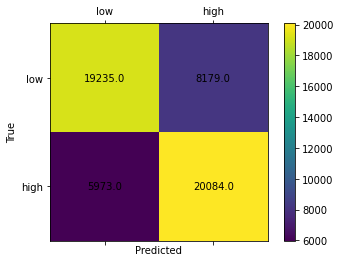

In [46]:
cutoff = 0.50
print_results(y_test, pred_rating_w2v_ave, cutoff, labels = ['low', 'high'])

### word2vec + tfidf

In [37]:
create_table(y_test, pred_rating_w2v_tfidf, threshold_chunck_size=0.05)

/home/rmehrizi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app
/home/rmehrizi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


             ppv  sensitivity       npv  specificity  f1 score
cutoff                                                        
0.00    0.487311     1.000000       NaN     0.000000  0.655291
0.05    0.506154     0.997505  0.969325     0.074925  0.671550
0.10    0.523914     0.994243  0.962705     0.141242  0.686224
0.15    0.542693     0.987144  0.944847     0.209346  0.700357
0.20    0.562272     0.977357  0.927855     0.276793  0.713861
0.25    0.583777     0.963119  0.908319     0.347304  0.726936
0.30    0.609011     0.940477  0.882784     0.426096  0.739290
0.35    0.639328     0.903749  0.849252     0.515394  0.748883
0.40    0.684331     0.829144  0.796712     0.636463  0.749809
0.45    0.715832     0.761600  0.758739     0.712629  0.738007
0.50    0.734118     0.713129  0.734543     0.754505  0.723471
0.55    0.757856     0.647887  0.705882     0.803239  0.698570
0.60    0.774408     0.603638  0.688540     0.832859  0.678442
0.65    0.789482     0.543309  0.665157     0.862297  0

              precision    recall  f1-score   support

           0       0.73      0.75      0.74     27414
           1       0.73      0.71      0.72     26057

    accuracy                           0.73     53471
   macro avg       0.73      0.73      0.73     53471
weighted avg       0.73      0.73      0.73     53471

[[20684  6730]
 [ 7475 18582]]


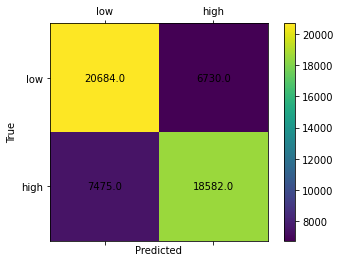

In [47]:
cutoff = 0.50
print_results(y_test, pred_rating_w2v_tfidf, cutoff, labels = ['low', 'high'])

### doc2vec

In [48]:
create_table(y_test, pred_rating_d2v, threshold_chunck_size=0.05)

/home/rmehrizi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app
/home/rmehrizi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/home/rmehrizi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


             ppv  sensitivity       npv  specificity  f1 score
cutoff                                                        
0.00    0.487311     1.000000       NaN     0.000000  0.655291
0.05    0.487311     1.000000       NaN     0.000000  0.655291
0.10    0.487311     1.000000       NaN     0.000000  0.655291
0.15    0.487311     1.000000       NaN     0.000000  0.655291
0.20    0.487320     1.000000  1.000000     0.000036  0.655299
0.25    0.487320     1.000000  1.000000     0.000036  0.655299
0.30    0.487446     0.999846  0.826087     0.000693  0.655380
0.35    0.488430     0.995587  0.678771     0.008864  0.655349
0.40    0.497223     0.948382  0.643331     0.088495  0.652402
0.45    0.524969     0.691484  0.580187     0.405267  0.596830
0.50    0.553321     0.432897  0.553363     0.667834  0.485757
0.55    0.598321     0.191503  0.533203     0.877800  0.290142
0.60    0.655357     0.014085  0.514468     0.992960  0.027576
0.65    0.714286     0.000384  0.512749     0.999854  0

              precision    recall  f1-score   support

           0       0.55      0.67      0.61     27414
           1       0.55      0.43      0.49     26057

    accuracy                           0.55     53471
   macro avg       0.55      0.55      0.55     53471
weighted avg       0.55      0.55      0.55     53471

[[18308  9106]
 [14777 11280]]


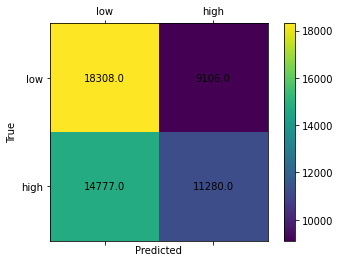

In [49]:
cutoff = 0.50
print_results(y_test, pred_rating_d2v, cutoff, labels = ['low', 'high'])

### Conclusion <a name='6'></a>

The best results are achieved by w2v embedding methods. Using average for calculating document embedding only slightly outperformed using TFIDF (accuracy of 0.74 vs 0.73). The performance of doc2vec is very poor (accuracy of 0.55). It might happen due to using a small dataset, which is not ideal when using doc2vec. The future work could be experimenting with pre-trained doc2vec, that are already trained on a very big dataset.